In [1]:
import uproot 
import numpy as np
import coffea
from coffea.nanoaod import NanoEvents
from coffea.nanoaod.methods.leptons import *
from coffea import hist
import matplotlib.pyplot as plt

In [2]:
fname="/uscms/home/ahall/nobackup/public/forTamas/iDM_nanoaod.root"
events = NanoEvents.from_file(fname,methods={"ElectronBPark":Electron})

In [3]:
#cuts on MET and Jet
MET_mask = events.MET.pt >120
Jet_mask = events.Jet.pt.max() > 80
MET_Jet_mask = MET_mask & Jet_mask

soft_eles = events[MET_Jet_mask].ElectronBPark

GenPart_mask = ((abs(events[MET_Jet_mask].GenPart.pdgId) == 11) 
               & (events[MET_Jet_mask].GenPart.parent.pdgId == 1000023)
               & (events[MET_Jet_mask].GenPart.status == 1) 
               & (events[MET_Jet_mask].GenPart.hasFlags(["fromHardProcess", "isFirstCopy"])))

#delta_r criteria for matched and unmatched electrons
eles = soft_eles.cross(events[MET_Jet_mask].GenPart[GenPart_mask], nested=True)
matched_mask = ((eles.i0.delta_r(eles.i1)).min() < 0.005)
unmatched_mask = ((eles.i0.delta_r(eles.i1)).min() >= 0.005)
matched_eles = soft_eles[matched_mask & (soft_eles.isPF == False)]
unmatched_eles = soft_eles[unmatched_mask & (soft_eles.isPF == False)]

In [28]:
# print(len(matched_eles.flatten()))
# print(len(soft_eles[(eles.i0.delta_r(eles.i1)).min() < 0.005].flatten()))
# x=0
# for i in matched_eles.mvaId.flatten():
#     if i==20:
#         x=x+1
# print(x)

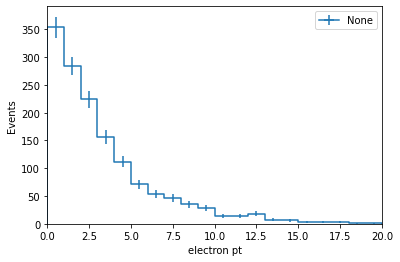

In [5]:
# masked Gen ele pt.
histo_gen_pt= hist.Hist(
            "Events",
            hist.Bin("ele_pt", "electron pt", 20, 0, 20),
        )
histo_gen_pt.fill(ele_pt=events[MET_Jet_mask].GenPart[GenPart_mask].pt.flatten())
hist.plot1d(histo_gen_pt)

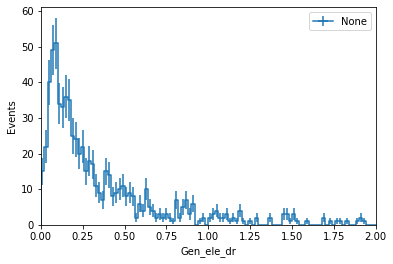

In [6]:
# masked Gen Ele dr
histo_gen_dr = hist.Hist(
            "Events",
            hist.Bin("gen_ele_dr", "Gen_ele_dr", 100, 0, 2),
        )
genEle_pairs = events[MET_Jet_mask].GenPart[GenPart_mask].distincts(nested=True)
histo_gen_dr.fill(gen_ele_dr=genEle_pairs.i0.delta_r(genEle_pairs.i1).min().flatten())
hist.plot1d(histo_gen_dr)

(0.0, 0.5)

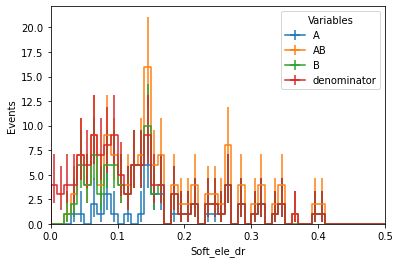

In [7]:
matched_pairs = matched_eles.distincts(nested=True)

# applying pt cut only on one of the electrons from the pair
matched_pairsA = matched_pairs[(matched_pairs.i0.pt < 5) & (matched_pairs.i0.pt > 1)]
matched_pairsB = matched_pairs[(matched_pairs.i1.pt < 5) & (matched_pairs.i1.pt > 1)]

delta_r = (matched_pairs.i0.delta_r(matched_pairs.i1)).min()
delta_rA = (matched_pairsA.i0.delta_r(matched_pairsA.i1)).min()
delta_rB = (matched_pairsB.i0.delta_r(matched_pairsB.i1)).min()

#AB contains duplicates where both values are within pt range
delta_rAB = np.append(delta_rA.flatten().tolist(), delta_rB.flatten().tolist())

histo_dr_all = hist.Hist(
            "Events",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_dr", 50, 0, 0.5),
        )

# denominator with no pt cut
histo_dr_all.fill(variables="denominator", soft_ele = delta_r.flatten())
# with pt cuts
histo_dr_all.fill(variables="A", soft_ele = delta_rA.flatten())
histo_dr_all.fill(variables="B", soft_ele = delta_rB.flatten())
histo_dr_all.fill(variables="AB", soft_ele = delta_rAB)

ax_delta_r=hist.plot1d(histo_dr_all)
ax_delta_r.set_xlim(right=0.5, left=0)

In [34]:
def cut(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
    ]

# def cut1(electrons):
#     return electrons[
#         (electrons.pt > 1) & (electrons.pt<5)
#         & (abs(electrons.eta) < 1.4)
#         & (electrons.ip3d < 5)
#         & (abs(electrons.dz) < 15)
#         & (abs(electrons.dxy) < 0.1)
#         #& (electrons.trkRelIso < 15)#Why is this so significant
#     ]
def cut2(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
        & (electrons.ip3d < 0.5)
        & (electrons.sip3d < 100)
        & (abs(electrons.dz) < 0.25)
         & (abs(electrons.dxy) < 0.3)
        &(electrons.ptBiased > 0)
        & (electrons.unBiased >0)
    ]

# def cuttest(electrons):
#     return electrons

In [51]:
import operator
# calculates the number of fakes per event
# parameter "electrons": jagged array of events
# paramter "good_cut": cut on electrons
# returns a list containing the umber of fakes per event
def numfakes(electrons, good_cut, match_mask):
    x=[]
    for i in good_cut(electrons):
        x.append(len(i))
    y=[]
    for i in good_cut(electrons[match_mask]):
        y.append(len(i))
    return list(map(operator.sub, x, y))

In [74]:
# print(numfakes(soft_eles, cuttest, matched_mask))
# print("-------------------------------------------------------------------")
# print(numfakes(soft_eles, cut, matched_mask))
# np.array(numfakes(soft_eles, cut2, matched_mask))

2.800139275766017


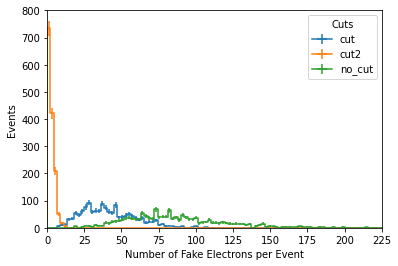

In [112]:
histo_numfakes= hist.Hist(
            "Events",
            hist.Cat("cuts", "Cuts"),
            hist.Bin("numfakes", "Number of Fake Electrons per Event", 100, 0, 225),
        )

histo_numfakes.fill(cuts="no_cut", numfakes = np.array(numfakes(soft_eles, cuttest, matched_mask)))
histo_numfakes.fill(cuts="cut", numfakes = np.array(numfakes(soft_eles, cut, matched_mask)))
histo_numfakes.fill(cuts="cut2", numfakes = np.array(numfakes(soft_eles, cut2, matched_mask)))

print(sum(numfakes(soft_eles, cut2, matched_mask))/len(numfakes(soft_eles, cut2, matched_mask)))
hist.plot1d(histo_numfakes)

In [60]:
np.array(numfakes(soft_eles, cuttest, matched_mask), dtype=int)

array([ 80,  61, 120, ..., 116, 107,  56])

In [94]:
#----------------------------------------------------------------------------
# pt efficiency curves
#----------------------------------------------------------------------------
histo_all = hist.Hist(
            "All",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt", 30, 1, 5),
        )

histo_all.fill(variables="denominator", soft_ele = cut(matched_eles).pt.flatten())

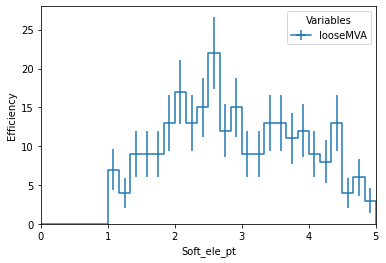

In [95]:
hist.plot1d(histo_eff_cut2)

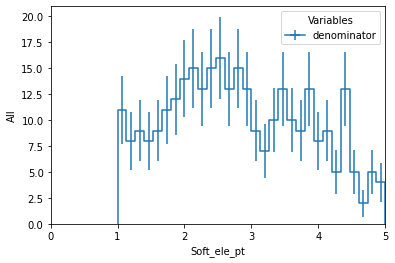

In [96]:
hist.plot1d(histo_all)

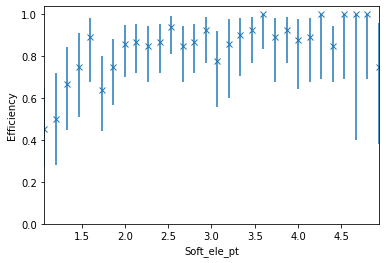

In [97]:
#pt efficiency curve for cuts

histo_eff_cut2 = hist.Hist(
            "Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt", 30, 1, 5),
        )
histo_eff_cut2.fill(variables="looseMVA", soft_ele = cut2(matched_eles).pt.flatten())
%matplotlib inline
hist.plotratio(num=histo_eff_cut2.integrate("variables"), denom=histo_all.integrate("variables"), error_opts={"marker": "x"})

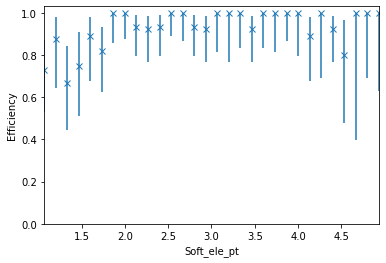

In [98]:
def cut_loose(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
        & (electrons.mvaId > 0)
    ]

histo_loose = hist.Hist(
            "Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt", 30, 1, 5),
        )
histo_loose.fill(variables="looseMVA", soft_ele = cut_loose(matched_eles).pt.flatten())
%matplotlib inline
hist.plotratio(num=histo_loose.integrate("variables"), denom=histo_all.integrate("variables"), error_opts={"marker": "x"})

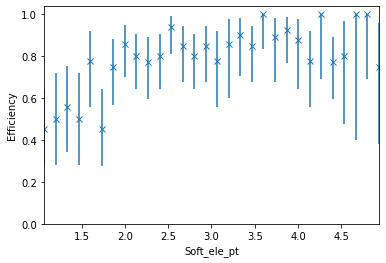

In [99]:
def cut_tight(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
        & (electrons.mvaId > 0) 
        & (abs(electrons.dz)<0.25) 
        & (abs(electrons.dxy<0.3))
        &(electrons.sip3d < 100)
        & (electrons.ptBiased>0)
        & (electrons.unBiased > 0)
        & (electrons.ip3d < 0.5)
    ]

histo_tight = hist.Hist(
            "Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt", 30, 1, 5),
        )
histo_tight.fill(variables="looseMVA", soft_ele = cut_tight(matched_eles).pt.flatten())
%matplotlib inline
hist.plotratio(num=histo_tight.integrate("variables"), denom=histo_all.integrate("variables"), error_opts={"marker": "x"})

In [104]:
#---------------------------------------------------------------------
# Efficiency curves with respect to dxy
#---------------------------------------------------------------------

histo_dxy_all = hist.Hist(
            "All",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_dxy", 40, -0.4, 0.4),
        )
histo_dxy_all.fill(variables="denominator", soft_ele = cut(matched_eles).dxy.flatten())

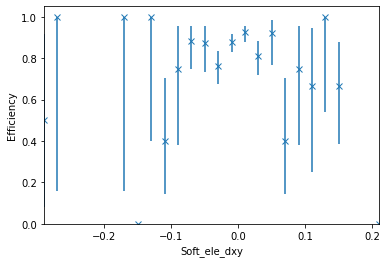

In [105]:
histo_effdxy_cut2 = hist.Hist(
            "Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_dxy", 40, -0.4, 0.4),
        )
histo_effdxy_cut2.fill(variables="looseMVA", soft_ele = cut2(matched_eles).dxy.flatten())
%matplotlib inline
hist.plotratio(num=histo_effdxy_cut2.integrate("variables"), denom=histo_dxy_all.integrate("variables"), error_opts={"marker": "x"})

(-0.4, 0.4)

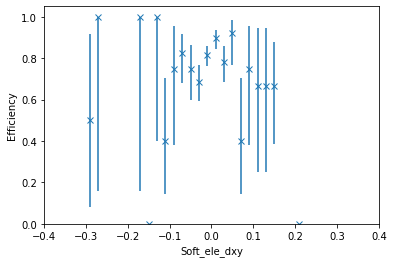

In [106]:
histo_dxy_tight = hist.Hist(
            "Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_dxy", 40, -0.4, 0.4),
        )
histo_dxy_tight.fill(variables="looseMVA", soft_ele = cut_tight(matched_eles).dxy.flatten())
%matplotlib inline
ax_dxy_eff = hist.plotratio(num=histo_dxy_tight.integrate("variables"), denom=histo_dxy_all.integrate("variables"), error_opts={"marker": "x"})
ax_dxy_eff.set_xlim(right=0.4, left=-0.4)

(-0.2, 0.2)

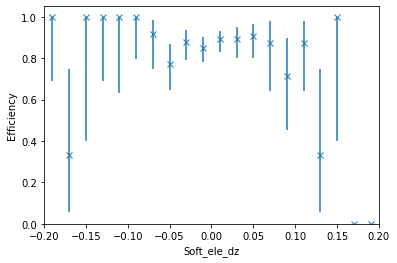

In [109]:
#--------------------------------------------------------------------
#Efficiency curves with respect to dz
#--------------------------------------------------------------------

histo_dz_all = hist.Hist(
            "All",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_dz", 20, -0.2, 0.2),
        )
histo_dz_all.fill(variables="denominator", soft_ele = cut(matched_eles).dz.flatten())

histo_dz_tight = hist.Hist(
            "Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_dz", 20, -0.2, 0.2),
        )
histo_dz_tight.fill(variables="looseMVA", soft_ele = cut_tight(matched_eles).dz.flatten())
%matplotlib inline
ax_dz_eff = hist.plotratio(num=histo_dz_tight.integrate("variables"), denom=histo_dz_all.integrate("variables"), error_opts={"marker": "x"})
ax_dz_eff.set_xlim(right=0.2, left=-0.2)

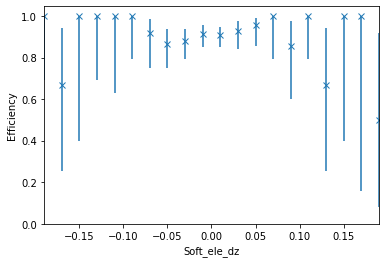

In [111]:
histo_effdz_cut2 = hist.Hist(
            "Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_dz", 20, -0.2, 0.2),
        )
histo_effdz_cut2.fill(variables="looseMVA", soft_ele = cut2(matched_eles).dz.flatten())
%matplotlib inline
hist.plotratio(num=histo_effdz_cut2.integrate("variables"), denom=histo_dz_all.integrate("variables"), error_opts={"marker": "x"})

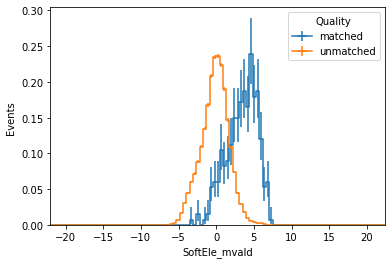

In [85]:
histo_mvaId = hist.Hist(
            "Events ",
            hist.Cat("quality", "Quality"),
            hist.Bin("soft_unmatched_ele", "SoftEle_mvaId", 100, -22, 22),
        )

histo_mvaId.fill(quality ="matched", soft_unmatched_ele=cut(matched_eles).mvaId.flatten())
histo_mvaId.fill(quality ="unmatched", soft_unmatched_ele=cut(unmatched_eles).mvaId.flatten())


%matplotlib inline
hist.plot1d(histo_mvaId, overflow = "over", density = True)

(-0.4, 0.4)

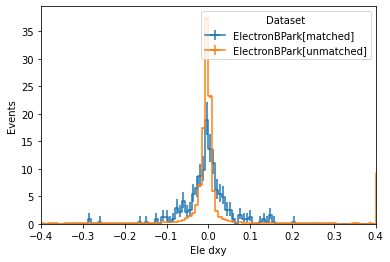

In [17]:
#guess cut: abs(0.3)
histo_dxy = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("dxy", "Ele dxy", 100, -0.4, 0.4),
        )
histo_dxy.fill(dataset ="ElectronBPark[matched]", dxy = cut(matched_eles).dxy.flatten())
histo_dxy.fill(dataset ="ElectronBPark[unmatched]", dxy = cut(unmatched_eles).dxy.flatten())
%matplotlib inline
ax_dxy = hist.plot1d(histo_dxy, overflow = "over", density = True)
ax_dxy.set_xlim(right=0.4, left=-0.4)

(-0.5, 0.5)

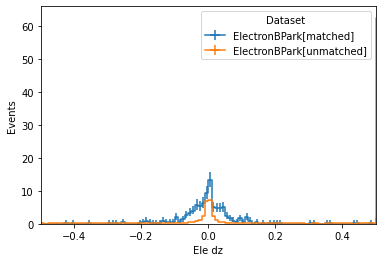

In [18]:
#guess cut: abs(0.25)
histo_dz = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("dz", "Ele dz", 100, -0.5, 0.5),
        )
histo_dz.fill(dataset ="ElectronBPark[matched]", dz = cut(matched_eles).dz.flatten())
histo_dz.fill(dataset ="ElectronBPark[unmatched]", dz = cut(unmatched_eles).dz.flatten())
%matplotlib inline
ax_dz = hist.plot1d(histo_dz, density = True, overflow = "over")
ax_dz.set_xlim(right=0.5, left=-0.5)

(0.0, 200.0)

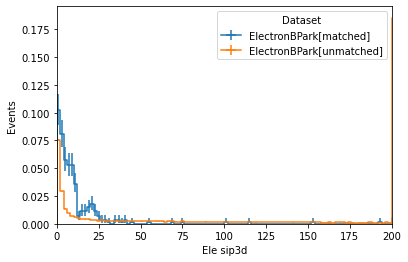

In [19]:
#guess cut: 100
histo_sip3d = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("sip3d", "Ele sip3d", 100, 0, 200),
        )
histo_sip3d.fill(dataset ="ElectronBPark[matched]", sip3d = cut(matched_eles).sip3d.flatten())
histo_sip3d.fill(dataset ="ElectronBPark[unmatched]", sip3d = cut(unmatched_eles).sip3d.flatten())
%matplotlib inline
ax_sip3d = hist.plot1d(histo_sip3d, density = True, overflow="over")
ax_sip3d.set_xlim(right=200, left=0)

(-25.0, 25.0)

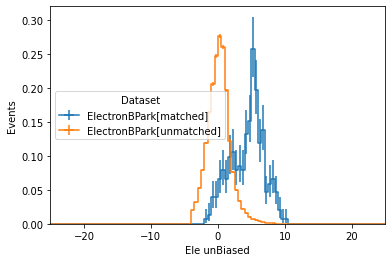

In [20]:
#guess cut: 0
histo_unBiased = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("unBiased", "Ele unBiased", 100, -25, 25),
        )
histo_unBiased.fill(dataset ="ElectronBPark[matched]", unBiased = cut(matched_eles).unBiased.flatten())
histo_unBiased.fill(dataset ="ElectronBPark[unmatched]", unBiased = cut(unmatched_eles).unBiased.flatten())
%matplotlib inline
ax_unBiased = hist.plot1d(histo_unBiased, density = True, overflow="over")
ax_unBiased.set_xlim(right=25, left=-25)

(-25.0, 25.0)

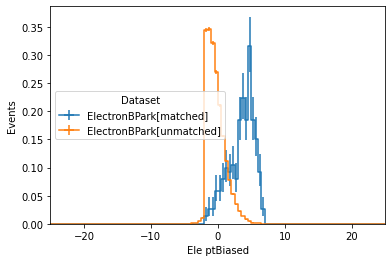

In [21]:
#guess cut:0
histo_ptBiased = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("ptBiased", "Ele ptBiased", 100, -25, 25),
        )
histo_ptBiased.fill(dataset ="ElectronBPark[matched]", ptBiased = cut(matched_eles).ptBiased.flatten())
histo_ptBiased.fill(dataset ="ElectronBPark[unmatched]", ptBiased = cut(unmatched_eles).ptBiased.flatten())
%matplotlib inline
ax_ptBiased = hist.plot1d(histo_ptBiased, density = True, overflow="over")
ax_ptBiased.set_xlim(right=25, left=-25)

(0.0, 0.5)

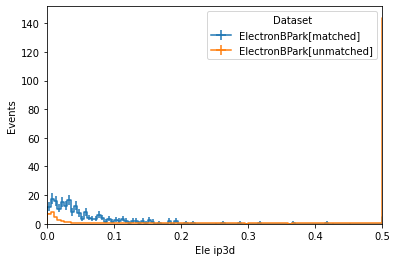

In [22]:
#guess cut: 0.5
histo_ip3d = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("ip3d", "Ele ip3d", 100, 0, 0.5),
        )
histo_ip3d.fill(dataset ="ElectronBPark[matched]", ip3d = cut(matched_eles).ip3d.flatten())
histo_ip3d.fill(dataset ="ElectronBPark[unmatched]", ip3d = cut(unmatched_eles).ip3d.flatten())
%matplotlib inline
ax_ip3d = hist.plot1d(histo_ip3d, density = True, overflow="over")
ax_ip3d.set_xlim(right=0.5, left=0)

In [23]:
#----------------------------------------------------------------------------
# ROC plots 
#----------------------------------------------------------------------------
def makeroc(sig, bkg, binning, direction=1):
    '''Given a signal and background discriminant array, along with a binning,
    compute the ROC curve by integrating discriminant histograms along a direction:
        1: cut < value
        -1: cut >= value
    Returns a tuple of (signal efficiency, background efficiency)'''
    sighist, _ = np.histogram(sig, bins=binning)
    bkghist, _ = np.histogram(bkg, bins=binning)
    # numpy histogram will ignore values out of range of our binning (overflow)
    # so add the overflow values that would pass given our cut direction
    if direction == 1:
        sighist[0] += sum(sig < binning[0])
        bkghist[0] += sum(bkg < binning[0])
    elif direction == -1:
        sighist[-1] += sum(sig > binning[-1])
        bkghist[-1] += sum(bkg > binning[-1])
    else:
        raise ValueError("Invalid direction")
    sigpass = (np.cumsum(sighist[::direction]) / len(sig))[::direction]
    bkgpass = (np.cumsum(bkghist[::direction]) / len(bkg))[::direction]
    return (sigpass, bkgpass)

In [24]:
#------------------------------------------------------------------------
# ROC with respect to mvaID
#------------------------------------------------------------------------
roc_mva_cut= makeroc(
    sig=cut(matched_eles.flatten()).mvaId,
    bkg=cut(unmatched_eles.flatten()).mvaId,
    binning=np.linspace(-15, 25, 80),
    direction=-1,
)

# roc_mva_cut1= makeroc(
#     sig=cut1(matched_eles.flatten()).mvaId,
#     bkg=cut1(unmatched_eles.flatten()).mvaId,
#     binning=np.linspace(-15, 25, 80),
#     direction=-1,
# )

roc_mva_cut2= makeroc(
    sig=cut2(matched_eles.flatten()).mvaId,
    bkg=cut2(unmatched_eles.flatten()).mvaId,
    binning=np.linspace(-15, 25, 80),
    direction=-1,
)

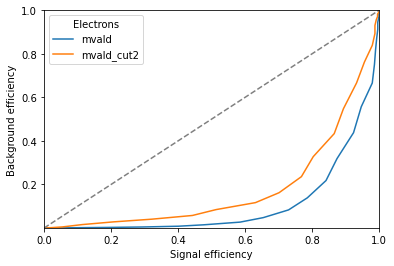

In [25]:
fig1, ax1 = plt.subplots()

ax1.plot(*roc_mva_cut, label=r"mvaId")
# ax1.plot(*roc_mva_cut1, label=r"mvaId_cut1")
ax1.plot(*roc_mva_cut2, label=r"mvaId_cut2")
diag = np.linspace(0, 1, 100)
ax1.plot(diag, diag, color='grey', linestyle='--')
ax1.set_xlabel("Signal efficiency")
ax1.set_ylabel("Background efficiency")
ax1.set_xlim(0, 1)
ax1.set_ylim(1e-3, 1)
# ax1.set_yscale('log')
ax1.legend(title=r'Electrons')

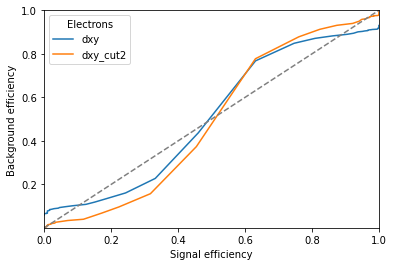

In [26]:
#-------------------------------------------------------------
# ROC dxy
#-------------------------------------------------------------
def cut_dxy2(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
        & (electrons.ip3d < 0.5)
        & (electrons.sip3d < 100)
        & (abs(electrons.dz) < 0.25)
        #& (abs(electrons.dxy) < 0.3)
        &(electrons.ptBiased > 0)
        & (electrons.unBiased >0)
    ]

roc_dxy_cut= makeroc(
    sig=cut(matched_eles.flatten()).dxy,
    bkg=cut(unmatched_eles.flatten()).dxy,
    binning=np.linspace(-0.4, 0.4, 80),
    direction=1,
)
roc_dxy_cut2= makeroc(
    sig=cut_dxy2(matched_eles.flatten()).dxy,
    bkg=cut_dxy2(unmatched_eles.flatten()).dxy,
    binning=np.linspace(-0.4, 0.4, 80),
    direction=1,
)

fig2, ax2 = plt.subplots()
ax2.plot(*roc_dxy_cut, label=r"dxy")
ax2.plot(*roc_dxy_cut2, label=r"dxy_cut2")
diag = np.linspace(0, 1, 100)
ax2.plot(diag, diag, color='grey', linestyle='--')
ax2.set_xlabel("Signal efficiency")
ax2.set_ylabel("Background efficiency")
ax2.set_xlim(0, 1)
ax2.set_ylim(1e-3, 1)
# ax1.set_yscale('log')
ax2.legend(title=r'Electrons')

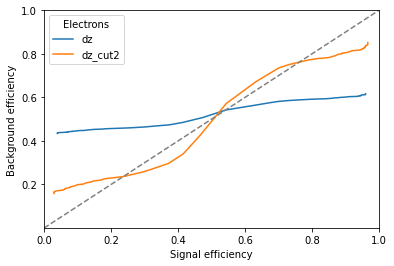

In [27]:
#-------------------------------------------------------------
# ROC dz
#-------------------------------------------------------------
def cut_dz2(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
        & (electrons.ip3d < 0.5)
        & (electrons.sip3d < 100)
        #& (abs(electrons.dz) < 0.25)
        & (abs(electrons.dxy) < 0.3)
        &(electrons.ptBiased > 0)
        & (electrons.unBiased >0)
    ]

roc_dz_cut= makeroc(
    sig=cut(matched_eles.flatten()).dz,
    bkg=cut(unmatched_eles.flatten()).dz,
    binning=np.linspace(-0.25, 0.25, 80),
    direction=1,
)
roc_dz_cut2= makeroc(
    sig=cut_dz2(matched_eles.flatten()).dz,
    bkg=cut_dz2(unmatched_eles.flatten()).dz,
    binning=np.linspace(-0.25, 0.25, 80),
    direction=1,
)

fig2, ax2 = plt.subplots()
ax2.plot(*roc_dz_cut, label=r"dz")
ax2.plot(*roc_dz_cut2, label=r"dz_cut2")
diag = np.linspace(0, 1, 100)
ax2.plot(diag, diag, color='grey', linestyle='--')
ax2.set_xlabel("Signal efficiency")
ax2.set_ylabel("Background efficiency")
ax2.set_xlim(0, 1)
ax2.set_ylim(1e-3, 1)
# ax1.set_yscale('log')
ax2.legend(title=r'Electrons')